In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

from lbl2vec import Lbl2Vec, Lbl2TransformerVec

from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

import spacy

In [53]:
def get_spacy_similar_words_for_dataset(dataset_name, keywords_by_class, save_cache=False):
    documents_df = pd.read_csv(f'../datasets/data/{dataset_name}/documents.csv')

    spacy_similarity_model = spacy.load('en_core_web_lg')
    resulting_keywords = {}

    all_documents_words = []
    for doc in documents_df[documents_df['dataset_type'] == 'train']['document']:
        all_documents_words.extend(doc.split(' '))
    all_documents_words = list(set(all_documents_words))

    for class_name, class_keyword in keywords_by_class.items():
        print(f'[INFO] Processing class keywords: {class_keyword}...' + ' ' * 20, end='\r')

        spacy_word_2 = []
        for keyword in class_keyword:
            spacy_word_2.append(spacy_similarity_model(keyword))

        similarity_levels = []
        
        for word in all_documents_words:
            spacy_word_1 = spacy_similarity_model(word)

            condition_2 = False
            for spacy_word in spacy_word_2:
                if spacy_word and spacy_word.vector_norm:
                    condition_2 = True
                    break

            if not (spacy_word_1 and spacy_word_1.vector_norm and condition_2):
                continue

            similarity_level = []
            for spacy_word in spacy_word_2:
                similarity_level.append(spacy_word_1.similarity(spacy_word))
            similarity_level = np.mean(similarity_level)

            similarity_levels.append((word, similarity_level))

        similarity_levels = sorted(similarity_levels, key=lambda x: x[1], reverse=True)
        resulting_keywords[class_name] = [word for word, _ in similarity_levels]
        
    cache_df = pd.DataFrame()
    cache_df['class_raw_keywords'] = keywords_by_class.values()
    cache_df['class_result_keywords'] = [resulting_keywords[keyword] for keyword in keywords_by_class.keys()]

    if save_cache:
        cache_df.to_csv(f'cache/{dataset_name}_spacy_keywords.csv', index=False)

    return cache_df

In [54]:
get_spacy_similar_words_for_dataset('SimpleDataset', {
    'food': ['food', 'meal'],
    'animal': ['animal', 'dog'],
}, save_cache=True)

,class_raw_keywords,class_result_keywords
0,"[food, meal]","[food, meal, eat, snack, breakfast, delicious,..."
1,"[animal, dog]","[animals, cats, bird, food, bears, fish, hunt,..."


In [55]:
def evaluate_lbl2transformervec_on_dataset(dataset_name: str, keywords_by_class: dict):
    # -- Documents
    documents_df = pd.read_csv(f'../datasets/data/{dataset_name}/documents.csv')
    documents_df['doc_key'] = documents_df.index.astype(str)

    # -- Labels
    labels_df = pd.read_csv(f'../datasets/data/{dataset_name}/labels.csv')
    labels_df['class_keywords'] = labels_df['class_name'].apply(lambda class_name: ' '.join(keywords_by_class[class_name]))
    labels_df['number_of_keywords'] = labels_df['class_keywords'].apply(lambda keywords: len(keywords))

    documents_df['class_keywords'] = documents_df['class_name'].apply(lambda class_name: labels_df[labels_df['class_name'] == class_name]['class_keywords'].values[0])

    # -- Evaluation
    print(f'[INFO] {dataset_name}...' + ' ' * 20, end='\r')

    # -- Model
    lbl2vec_model = Lbl2TransformerVec(
        keywords_list=[item.split(' ') for item in labels_df['class_keywords']], 
        documents=list(documents_df['document'][documents_df['dataset_type'] == 'train']), 
        label_names=[item for item in labels_df['class_keywords']], 
        verbose=False
    )
    lbl2vec_model.fit()

    train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
    test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(documents=documents_df['document'][documents_df['dataset_type'] == 'test'])

    train_docs_lbl_similarities['doc_key'] = list(documents_df['doc_key'][documents_df['dataset_type'] == 'train'])
    test_docs_lbl_similarities['doc_key'] = list(documents_df['doc_key'][documents_df['dataset_type'] == 'test'])

    evaluation_train = train_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
    evaluation_test = test_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

    y_true_train = evaluation_train['class_keywords']
    y_pred_train = evaluation_train['most_similar_label']

    y_true_test = evaluation_test['class_keywords']
    y_pred_test = evaluation_test['most_similar_label']

    current_f1_score_train_by_class = f1_score(y_true_train, y_pred_train, average=None)
    current_f1_score_test_by_class = f1_score(y_true_test, y_pred_test, average=None)

    return current_f1_score_train_by_class, current_f1_score_test_by_class

In [71]:
def evaluate_lbl2vec_on_dataset(dataset_name: str, keywords_by_class: dict, n_iterations: int = 1, n_words: int = 1):
    def tokenize(doc):
        return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)
    
    # -- Documents
    documents_df = pd.read_csv(f'../datasets/data/{dataset_name}/documents.csv')
    documents_df['tagged_docs'] = documents_df.apply(
        lambda row: TaggedDocument(tokenize(row['document']), [str(row.name)]), axis=1
    )
    documents_df['doc_key'] = documents_df.index.astype(str)

    # -- Labels
    labels_df = pd.read_csv(f'../datasets/data/{dataset_name}/labels.csv')
    labels_df['class_keywords'] = labels_df['class_name'].apply(lambda class_name: ' '.join(keywords_by_class[class_name]))
    labels_df['number_of_keywords'] = labels_df['class_keywords'].apply(lambda keywords: len(keywords))

    keywords_cached_df = get_spacy_similar_words_for_dataset(dataset_name, keywords_by_class, save_cache=True)
    keywords_cached_df = pd.read_csv(f'cache/{dataset_name}_spacy_keywords.csv')

    keywords_cached_df['class_result_keywords'] = keywords_cached_df['class_result_keywords'].apply(lambda x: x[1:-1].replace("'", '').split(', '))
    keywords_cached_df['class_raw_keywords'] = [' '.join(item) for item in keywords_cached_df['class_raw_keywords'].apply(lambda x: x[1:-1].replace("'", '').split(', '))]

    similar_keywords = dict(zip(keywords_cached_df['class_raw_keywords'], keywords_cached_df['class_result_keywords']))
    
    labels_df['class_result_keywords'] = labels_df.apply(
        lambda row: similar_keywords[row['class_keywords']][:n_words], axis=1
    )
    documents_df['class_keywords'] = documents_df['class_name'].apply(lambda class_name: labels_df[labels_df['class_name'] == class_name]['class_keywords'].values[0])

    # -- Evaluation
    f1_scores_train_by_class = []
    f1_scores_test_by_class = []

    for i in range(n_iterations):
        print(f'[INFO] {dataset_name} | Iteration {i+1}/{n_iterations}...' + ' ' * 20, end='\r')

        # -- Model
        lbl2vec_model = Lbl2Vec(
            keywords_list=[item for item in labels_df['class_result_keywords']], 
            tagged_documents=list(documents_df['tagged_docs'][documents_df['dataset_type'] == 'train']), 
            label_names=[item for item in labels_df['class_keywords']], 
            min_count=1,
            verbose=False
        )
        lbl2vec_model.fit()

        train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
        test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(tagged_docs=documents_df['tagged_docs'][documents_df['dataset_type'] == 'test'])

        evaluation_train = train_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
        evaluation_test = test_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

        y_true_train = evaluation_train['class_keywords']
        y_pred_train = evaluation_train['most_similar_label']

        y_true_test = evaluation_test['class_keywords']
        y_pred_test = evaluation_test['most_similar_label']

        current_f1_score_train_by_class = f1_score(y_true_train, y_pred_train, average=None)
        current_f1_score_test_by_class = f1_score(y_true_test, y_pred_test, average=None)

        f1_scores_train_by_class.append(current_f1_score_train_by_class)
        f1_scores_test_by_class.append(current_f1_score_test_by_class)

    return np.mean(f1_scores_train_by_class, axis=0), np.mean(f1_scores_test_by_class, axis=0)

In [75]:
def plot_keywords_by_class_results(keywords_by_class, test_idx: int = 0):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Keywords by class', fontsize=16, fontweight='bold')

    title = ''
    for key, value in keywords_by_class.items():
        title += f'\n{key}: {value}'
    plt.text(.5, 0.86, title, transform=fig.transFigure, horizontalalignment='center')

    # -- Lbl2Vec
    train_f1_scores_by_class, test_f1_scores_by_class = evaluate_lbl2vec_on_dataset('SimpleDataset', keywords_by_class, n_iterations=5, n_words=20)

    scores_df = pd.DataFrame()
    scores_df['class'] = keywords_by_class.keys()
    scores_df['train'] = train_f1_scores_by_class
    scores_df['test'] = test_f1_scores_by_class
    scores_df = scores_df.melt(id_vars=['class'], var_name='dataset_type', value_name='f1_score')

    train_score, test_score = np.mean(train_f1_scores_by_class), np.mean(test_f1_scores_by_class)
    axs[0].set_title('Lbl2Vec (train: {:.2f} | test: {:.2f})'.format(train_score, test_score), fontsize=12, fontweight='bold')
    axs[0].set_xlabel('Class')
    axs[0].set_ylabel('F1 Score')
    
    sns.barplot(x='class', y='f1_score', hue='dataset_type', data=scores_df, ax=axs[0])
    axs[0].set_xticks(np.arange(len(keywords_by_class)))
    axs[0].set_xticklabels(keywords_by_class.keys())
    axs[0].legend()

    # -- Lbl2TransformerVec
    train_f1_scores_by_class, test_f1_scores_by_class = evaluate_lbl2transformervec_on_dataset('SimpleDataset', keywords_by_class)

    scores_df = pd.DataFrame()
    scores_df['class'] = keywords_by_class.keys()
    scores_df['train'] = train_f1_scores_by_class
    scores_df['test'] = test_f1_scores_by_class
    scores_df = scores_df.melt(id_vars=['class'], var_name='dataset_type', value_name='f1_score')

    train_score, test_score = np.mean(train_f1_scores_by_class), np.mean(test_f1_scores_by_class)
    axs[1].set_title('Lbl2TransformerVec (train: {:.2f} | test: {:.2f})'.format(train_score, test_score), fontsize=12, fontweight='bold')
    axs[1].set_xlabel('Class')
    axs[1].set_ylabel('F1 Score')

    sns.barplot(x='class', y='f1_score', hue='dataset_type', data=scores_df, ax=axs[1])
    axs[1].set_xticks(np.arange(len(keywords_by_class)))
    axs[1].set_xticklabels(keywords_by_class.keys())
    axs[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'../figures/simple_dataset_keywords_by_class_{test_idx}.png')

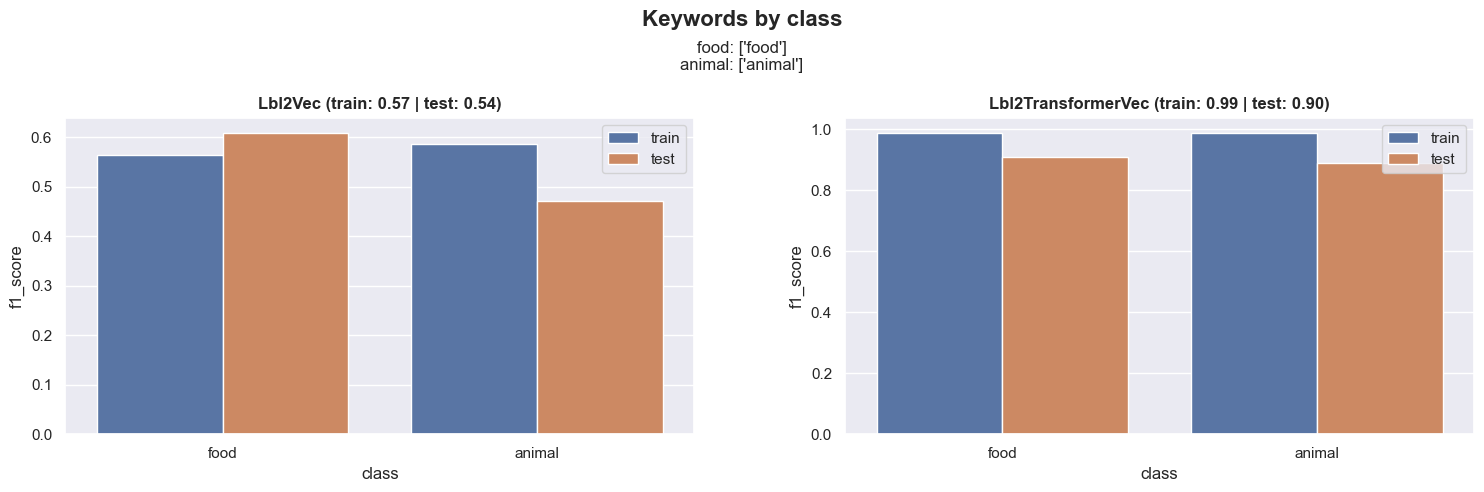

In [76]:
plot_keywords_by_class_results(keywords_by_class={
    'food': ['food'],
    'animal': ['animal'],
}, test_idx=0)

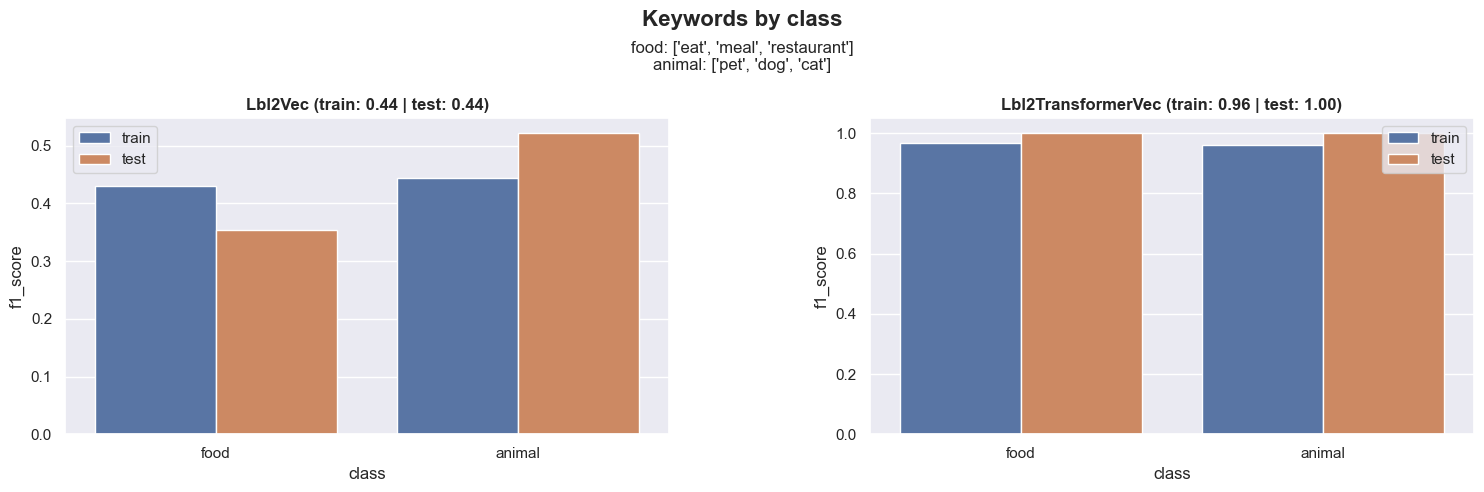

In [77]:
plot_keywords_by_class_results(keywords_by_class={
    'food': ['eat', 'meal', 'restaurant'],
    'animal': ['pet', 'dog', 'cat'],
}, test_idx=1)